In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

In [30]:
import numpy as np
import pandas as pd
import re
#from sentiment_utils import *
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
np.random.seed(1)
from sklearn.model_selection import train_test_split

#from emo_utils import *
import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words)

def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [32]:
#Read the data
train_df = pd.read_csv("Tweets.csv")
train_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [33]:
#check Different labels for Sentiment
Mood = train_df['airline_sentiment'].value_counts()

Text(0.5, 1.0, 'Mood Distribution')

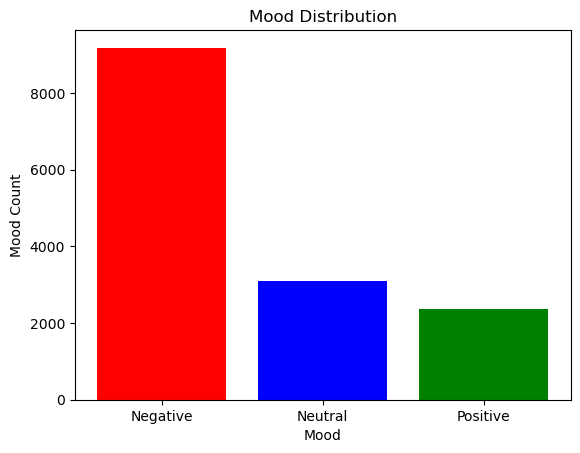

In [34]:
index = [1,2,3]
plt.bar(index,Mood,color=['r','b','g'])
plt.xticks(index,['Negative','Neutral','Positive'])
plt.xlabel('Mood')
plt.ylabel('Mood Count')
plt.title('Mood Distribution')

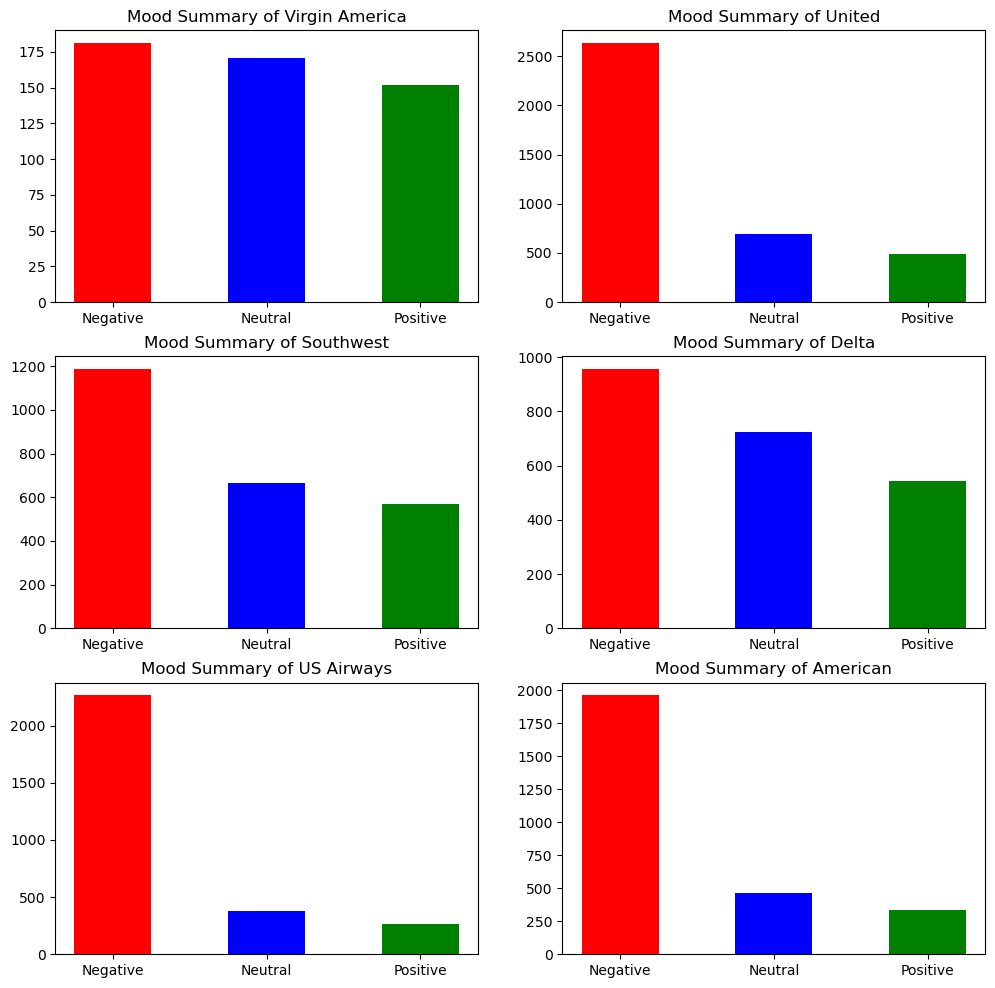

In [35]:
def plot_sub_sentiment(Airline):
    pdf = train_df[train_df['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color = ['red','blue','green']
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title('Mood Summary of' + " " + Airline)

airline_name = train_df['airline'].unique()
plt.figure(1,figsize=(12,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_sub_sentiment(airline_name[i])
plt.show()

In [36]:
#cleaning Data
train_df = train_df[['text', 'airline_sentiment']]
train_df.text = train_df.text.apply(remove_mentions)
train_df.loc[:,'sentiment'] = train_df.airline_sentiment.map({'negative':0,'neutral':1,'positive':2})
train_df = train_df.drop(['airline_sentiment'], axis=1)
train_df.head()

,text,sentiment
0,What said.,1
1,plus you've added commercials to the experien...,2
2,I didn't today... Must mean I need to take an...,1
3,"it's really aggressive to blast obnoxious ""en...",0
4,and it's a really big bad thing about it,0


In [37]:
#This step is to find the maximun length of the input string so as to fed the neural net with same length
raw_docs_train = train_df["text"].values
sentiment_train = train_df['sentiment'].values

maxLen = len(max(raw_docs_train, key=len).split())

In [38]:
#For our model we need to split our training dataset into test dataset. This is actually dev set for getting the loss
X_train, X_test, Y_train, Y_test = train_test_split(raw_docs_train, sentiment_train, 
                                                  stratify=sentiment_train, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]

# Train data samples: (13176,)
# Test data samples: (1464,)


In [39]:
#Convert the labels to One hot encoding vector for softmax for neural network

#Y_oh_train = convert_to_one_hot(Y_train, C = num_labels)
num_labels = len(np.unique(sentiment_train))
Y_oh_train = np_utils.to_categorical(Y_train, num_labels)
Y_oh_test = np_utils.to_categorical(Y_test, num_labels)
print(Y_oh_train.shape)

(13176, 3)


In [40]:
#Now we need Glove Vectors for Word which is available online 
#word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('Data/glove.6B.50d.txt')

# load the GloVe vectors in a dictionary:

def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [41]:
word = "cucumber"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [42]:
# This function convert array of strings into array of Indices of word in the voacab.

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =[word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except: 0
            # Increment j to j + 1
            j = j+1
    
    return X_indices

In [43]:
# Create Keras Embedding layer
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [44]:

def ltsm_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the ltsm_model model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices =  Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(3, activation=None)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [45]:
model = ltsm_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 26, 50)            20000050  
                                                                 
 lstm_2 (LSTM)               (None, 26, 128)           91648     
                                                                 
 dropout_2 (Dropout)         (None, 26, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387 

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
print(X_train_indices.shape)

(13176, 26)


In [48]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history = model.fit(X_train_indices, y=Y_oh_train, batch_size=512, epochs=20, 
          verbose=1, validation_data=(X_test_indices, Y_oh_test), callbacks=[earlystop])

Epoch 1/20
26/26 [==============================] - 13s 356ms/step - loss: 0.8707 - accuracy: 0.6171 - val_loss: 0.8225 - val_accuracy: 0.6270
Epoch 2/20
26/26 [==============================] - 8s 309ms/step - loss: 0.7789 - accuracy: 0.6703 - val_loss: 0.7063 - val_accuracy: 0.7104
Epoch 3/20
26/26 [==============================] - 8s 307ms/step - loss: 0.7111 - accuracy: 0.7080 - val_loss: 0.6734 - val_accuracy: 0.7357
Epoch 4/20
26/26 [==============================] - 8s 317ms/step - loss: 0.6694 - accuracy: 0.7284 - val_loss: 0.6556 - val_accuracy: 0.7357
Epoch 5/20
26/26 [==============================] - 8s 313ms/step - loss: 0.6493 - accuracy: 0.7340 - val_loss: 0.6465 - val_accuracy: 0.7363
Epoch 6/20
26/26 [==============================] - 9s 348ms/step - loss: 0.6299 - accuracy: 0.7435 - val_loss: 0.6347 - val_accuracy: 0.7425
Epoch 7/20
26/26 [==============================] - 10s 399ms/step - loss: 0.6140 - accuracy: 0.7442 - val_loss: 0.6149 - val_accuracy: 0.7486
Epoc

In [49]:
#Check Prediction for a particular example
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['Good Airlines'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  str(np.argmax(model.predict(X_test_indices))))

Good Airlines 2


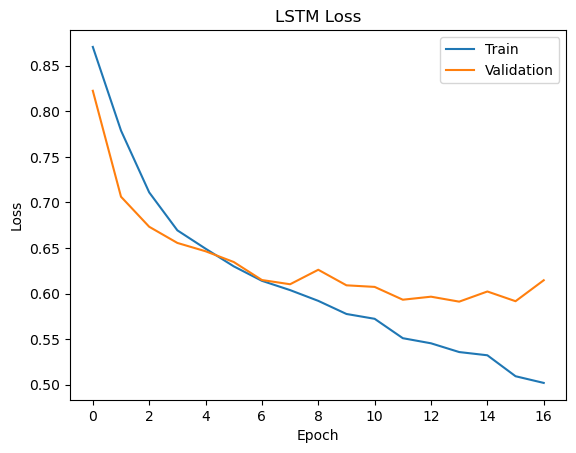

In [51]:
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

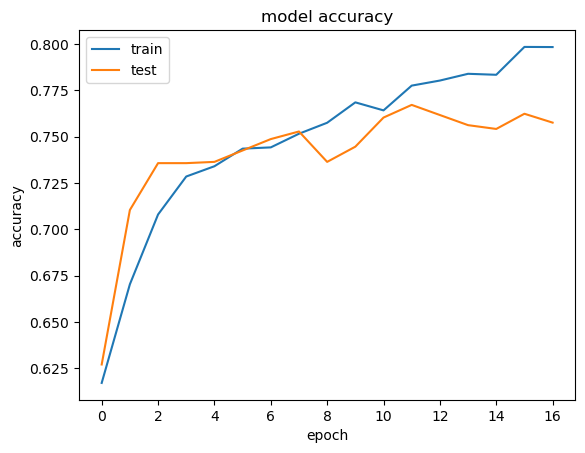

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
model.save("LSTM_model_test.h5")

In [60]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential
model = Sequential()
# model.add(Input(shape(None,26)
model.add(SimpleRNN(64, input_shape=(None, 26)))
model.add(Dense(3, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                5824      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6,019
Trainable params: 6,019
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = model.fit(X_train_indices, y=Y_oh_train, batch_size=512, epochs=20, 
          verbose=1, validation_data=(X_test_indices, Y_oh_test), callbacks=[earlystop])

Epoch 1/20


ValueError: in user code:

    File "C:\Users\Computer-_-\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Computer-_-\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Computer-_-\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Computer-_-\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Computer-_-\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Computer-_-\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).
    
    Input 0 of layer "simple_rnn_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 26)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 26), dtype=float32)
      • training=True
      • mask=None
